In [1]:
import pandas as pd
import numpy as np

import time

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import yellowbrick
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
print('pandas version : ', pd.__version__, '\n')
print('numpy version : ', np.__version__, '\n')
print('matplotlib version : ', matplotlib.__version__, '\n')
print('seaborn version : ', sns.__version__, '\n')
print('yellowbrick version : ', yellowbrick.__version__, '\n')
print('sklearn version : ', sklearn.__version__, '\n')
print('xgboost version :', xgb.__version__)

pandas version :  1.2.4 

numpy version :  1.19.5 

matplotlib version :  3.3.4 

seaborn version :  0.11.2 

yellowbrick version :  1.3.post1 

sklearn version :  1.0.2 

xgboost version : 1.5.1


# Fonctions

Nous allons créer 3 fonctions afin d'être plus efficace dans la prédiction de la consommation électrique et des émissions de CO2 de bâtiments. La première sera focalisée sur le preprocessing de nos données, la deuxième permettra d'appliquer un modèle de Machine Learning à nos données et la troisième permettra de réaliser une recherche en grille avec validation croisée.

In [3]:
#On supprime les avertissements nous indiquant que l'on change les valeurs de notre jeu de données d'origine
pd.options.mode.chained_assignment = None

In [4]:
def preprocessing(data, target):
    """
    Prend un DataFrame et le sépare en deux : des features et une target. Sépare ensuite ces features et cet target en jeux
    d'entraînement et en jeux de test. Les features numériques seront centrés et réduits. Les features catégorielles
    seront transformés en features numériques à l'aide d'un ColumnTransformer et d'un OneHotEncoder. 
    Retourne X_train (features d'entraînement), X_test (features de test), y_train (target d'entraînement) et y_test (target
    de test).

            Parameters:
                data : DataFrame à utiliser
                target : variable que l'on souhaite prédire
    """
    
    #On sépare notre jeu de données entre nos features (X) et notre target (y)
    X = data.drop(target, axis = 1)
    y = data[target]
    
    #On sépare nos features et notre target en jeux d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 24)
    
    #On centre et on réduit nos valeurs numériques
    columns_to_scale  = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking',\
                         'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',\
                         'AgeOfBuilding', '%GFAParking','%GFABuilding(s)', '%GFALargest', '%GFASecondLargest']

    std_scale = StandardScaler().fit(X_train[columns_to_scale])

    X_train[columns_to_scale] = std_scale.transform (X_train[columns_to_scale])
    X_test[columns_to_scale] = std_scale.transform(X_test[columns_to_scale])
    
    #On s'occupe de nos features catégorielles avec OneHotEncoder et ColumnTransformer
    columns_to_encode = ['Neighborhood','LargestPropertyUseType', 'SecondLargestPropertyUseType']

    ct = ColumnTransformer([('onehotencoder', OneHotEncoder(handle_unknown = 'ignore', sparse = False), columns_to_encode)],\
                           remainder = 'passthrough')

    X_train = ct.fit_transform(X_train)

    X_test = ct.transform(X_test)
    
    features = ct.get_feature_names_out()
    
    return(X_train, X_test, y_train, y_test, features)

In [5]:
#On crée un dictionnaire qui va contenir nos modèles les résultats associés et les temps de calcul
data_model = {}

def algo(model, X_train, X_test, y_train, y_test):
    """
    Prend un modèle de Machine Learning et l'applique à nos données précédemment fournies (X_train, X_test, y_train, y_test).
    Calcule le coefficient de détermination R2 du jeu d'entraînement et du jeu de test ainsi que l'erreur quadratique moyenne
    (RMSE) associée. Ajoute le nom du modèle, le coefficient de détermination R2 du jeu d'entraînement et du jeu de test, ainsi
    que l'erreur quadratique moyenne du jeu de test et le temps de calcul de la cellule à un DataFrame spécifique (data_test).
    
            Parameters:
                model : modèle que l'on souhaite tester
                X_train : features d'entraînement
                X_test : features de test
                y_train : target d'entraînement
                y_test : target de test
    """    
    #On souhaite savoir combien de temps nos modèles prennent à se faire
    t0 = time.time()
    
    #On entraîne notre modèle
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    #On calcule le temps de calcul
    t1 = time.time()
    
    #On remplit notre dataframe avec les modèles, les scores associés et les temps de calcul
    data_model.update({'{}'.format(model) : ['{:.4f}'.format(model.score(X_train, y_train)),\
                                             '{:.4f}'.format(model.score(X_test, y_test)),\
                                             '{:.2f}'.format(rmse), '{:.2f}'.format(round(t1 - t0, 2))]})

In [6]:
def algo_cv(model, params_grid, X_train, X_test, y_train, y_test):
    """
    Prend un modèle de Machine Learning et réalise un GridSearch et une validation croisée selon les paramètres spécifiés.
    Retourne les meilleurs hyparamètres du modèle choisi, le modèle à utiliser, le meilleur score moyen avec les meilleurs
    hyperparamètres de validation croisée (coefficient de détermination R2), l'erreur quadratique moyenne du meilleur modèle
    ainsi que le temps de calcul de la validation croisée.
    
            Parameters:
                model : modèle que l'on souhaite tester avec une validation croisée
                params_grid : les paramètres à tester
                X_train : features d'entraînement
                X_test : features de test
                y_train : target d'entraînement
                y_test : target de test
    """
    #On affiche le temps de calcul de la recherche croisée
    t0 = time.time()

    model_cv = GridSearchCV(model, params_grid, verbose = 1, cv = 5, scoring = 'r2')             

    model_cv.fit(X_train, y_train) 

    print("Les meilleurs hyperparamètres du modèle sont :", model_cv.best_params_, '\n')
    print("Le modèle à utiliser est :", model_cv.best_estimator_, '\n')

    best_model_cv = model_cv.best_estimator_
    
    #Score moyen des validations croisées du meilleur estimateur
    print("Le meilleur score avec ces hyperparamètres est : {:.4f}".format(model_cv.best_score_), '\n')

    #On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne avec les valeurs de la GridSearch
    y_pred_cv = best_model_cv.predict(X_test)
    rmse_cv = np.sqrt(mean_squared_error(y_test, y_pred_cv))
    print("RMSE_CV : {:.2f}".format(rmse_cv), '\n')
    
    #Temps de calcul :
    t1 = time.time()
    print('Temps de calcul :', round(t1 - t0, 2), 'secondes')

# Prédictions de la consommation électrique, sans ENERGYSTARScore

In [7]:
#On charge notre jeu de données
elec_no_star = pd.read_csv('P4_elec.csv')
elec_no_star.drop(columns = ['Unnamed: 0', 'ENERGYSTARScore'], inplace = True)
print('Notre jeu de données comporte :', elec_no_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [8]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = elec_no_star, target = 'SiteEnergyUse(kBtu)')

In [9]:
#Liste des modèles que nous allons utiliser sur nos jeux de données
modeles = [DummyRegressor(strategy = 'mean'), LinearRegression(), Ridge(), Lasso(tol = 1e-2), KNeighborsRegressor(),\
           RandomForestRegressor(), DecisionTreeRegressor(), AdaBoostRegressor(DecisionTreeRegressor()),\
           GradientBoostingRegressor(), XGBRegressor()]

In [10]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [11]:
#On regroupe nos résultats dans un DataFrame
df_elec_no_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                  'RMSE', 'Temps de calcul'])
df_elec_no_star.sort_values('Score de test', ascending = False, inplace = True)
df_elec_no_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9997,0.8555,0.51,1.25
RandomForestRegressor(),0.9774,0.8329,0.55,1.77
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9631,0.8191,0.57,0.26
GradientBoostingRegressor(),0.8061,0.7579,0.66,0.59
DecisionTreeRegressor(),1.0000,0.7252,0.70,0.03
KNeighborsRegressor(),0.7284,0.5410,0.91,0.05
Lasso(tol=0.01),0.2197,0.2284,1.18,0.01
LinearRegression(),0.6149,-34420063782.7149,248174.69,0.03
Ridge(),0.6125,-0.0311,1.36,0.01
DummyRegressor(),0.0000,-0.0018,1.34,0.00


## Validation croisée de nos meilleurs modèles pour prédire la consommation électrique des bâtiments sans ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 3 meilleurs modèles afin de déterminer quels sont les meilleurs hyperparamètres de ces modèles et quel est le modèle le plus adapté à notre problème.

In [12]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 3, 5], 'min_samples_leaf' : [1, 5, 10], 'n_estimators' : np.arange(100, 500, 100)}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=300) 

Le meilleur score avec ces hyperparamètres est : 0.8164 

RMSE_CV : 0.54 

Temps de calcul : 284.18 secondes


In [13]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 3, 5], 'base_estimator__min_samples_leaf' : [1, 5, 10],\
               'n_estimators' : np.arange(50, 300, 50),\
               'loss' : ['linear', 'square', 'exponential']}

algo_cv(AdaBoostRegressor(base_estimator = DecisionTreeRegressor()), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'loss': 'square', 'n_estimators': 100} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), loss='square',
                  n_estimators=100) 

Le meilleur score avec ces hyperparamètres est : 0.8326 

RMSE_CV : 0.51 

Temps de calcul : 946.44 secondes


In [14]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [4, 6, 8],\
               'gamma' : [ 0.0, 0.1, 0.2], 'n_estimators' : [100, 250, 500]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 8, 'n_estimators': 500} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.8374 

RMSE_CV : 0.53 

Temps de calcul : 224.33 secondes


# Analyse de notre meilleur modèle pour la prédiction de la consommation électrique de bâtiments

In [12]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

xgbr = XGBRegressor(gamma = 0.0, learning_rate = 0.15, max_depth = 8, n_estimators = 500) 

#On entraîne notre modèle
xgbr.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
xgbr_train = '{:.4f}'.format(xgbr.score(X_train, y_train))
xgbr_test = '{:.4f}'.format(xgbr.score(X_test, y_test))

print("Score d'entraînement : {}".format(xgbr_train), '\n')
print("Score de test : {}".format(xgbr_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = xgbr.predict(X_test)
xgbr_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred)))

print("RMSE : {}".format(xgbr_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
xgbr_time = round(t1 - t0, 2)

print('Temps de calcul :', xgbr_time, 'secondes')

Score d'entraînement : 0.9994 

Score de test : 0.8440 

RMSE : 0.53 

Temps de calcul : 1.44 secondes


On crée un dictionnaire qui va reprendre les informations relatives à nos meilleures modèles.

In [13]:
dict_final = {}

dict_final.update({'XGBoostRegressor' : [xgbr_train, xgbr_test, xgbr_rmse, xgbr_time]})

## Feature importance plot - Consommation électrique

<AxesSubplot:>

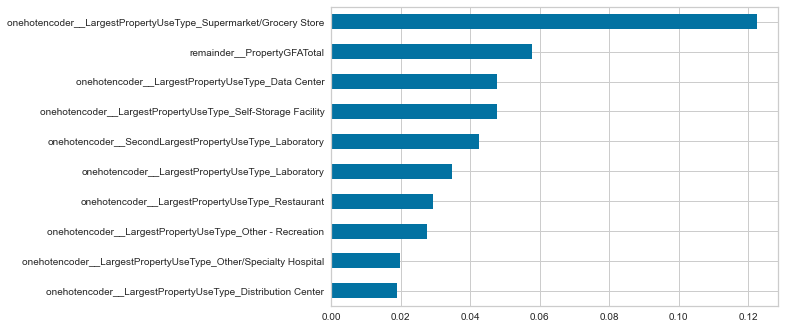

In [14]:
feat_importances_xgbr = pd.Series(xgbr.feature_importances_, index = features)

feat_importances_xgbr.nlargest(10).sort_values().plot(kind = 'barh')

## Learning curves plot - Consommation électrique

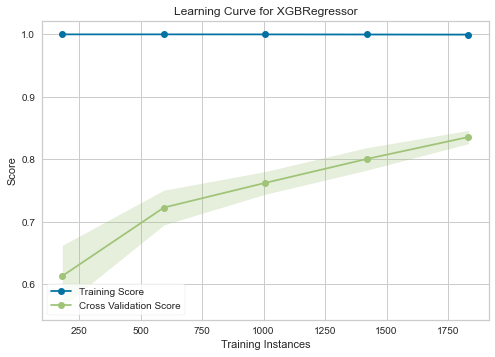

<AxesSubplot:title={'center':'Learning Curve for XGBRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [18]:
learning_curve_xgbr = LearningCurve(xgbr, scoring = 'r2')

learning_curve_xgbr.fit(X_train, y_train)
learning_curve_xgbr.show()

## Residual plot - Consommation électrique

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

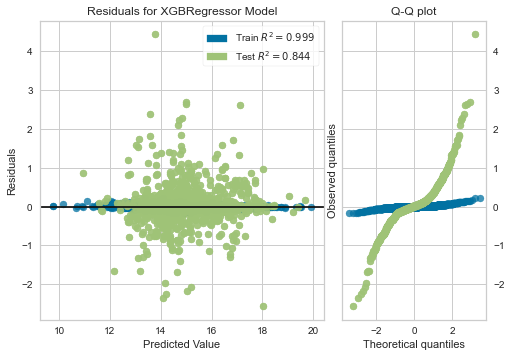

In [19]:
residual_plot_xgbr = ResidualsPlot(xgbr, hist = False, qqplot = True)

residual_plot_xgbr.fit(X_train, y_train)
residual_plot_xgbr.score(X_test, y_test) 
residual_plot_xgbr.finalize()

residuals = y_pred - y_test

residual_plot_xgbr.draw(y_pred, residuals) 

## Prediction Error plot - Consommation électrique

<AxesSubplot:title={'center':'Prediction Error for XGBRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

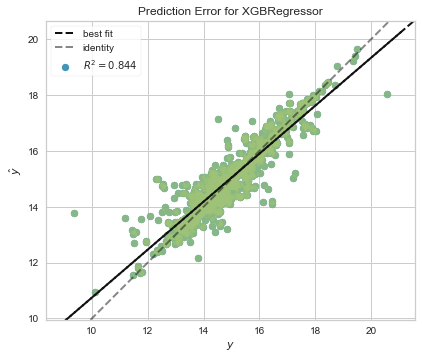

In [20]:
prediction_error_xgbr = PredictionError(xgbr)

prediction_error_xgbr.fit(X_train, y_train)
prediction_error_xgbr.score(X_test, y_test)
prediction_error_xgbr.finalize()

prediction_error_xgbr.draw(y_test, y_pred) 

# Prédictions de la consommation électrique, avec ENERGYSTARScore

In [15]:
#On charge notre jeu de données
elec_with_star = pd.read_csv('P4_elec.csv')
elec_with_star.drop(columns = ['Unnamed: 0'], inplace = True)
print('Notre jeu de données comporte :', elec_with_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [16]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = elec_with_star, target = 'SiteEnergyUse(kBtu)')

In [17]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [18]:
#On regroupe nos résultats dans un DataFrame
df_elec_with_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                    'RMSE', 'Temps de calcul'])
df_elec_with_star.sort_values('Score de test', ascending = False, inplace = True)
df_elec_with_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9997,0.8813,0.46,1.23
RandomForestRegressor(),0.9796,0.8524,0.51,1.74
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9783,0.8448,0.53,0.22
GradientBoostingRegressor(),0.8490,0.7962,0.60,0.61
DecisionTreeRegressor(),1.0000,0.7554,0.66,0.03
KNeighborsRegressor(),0.6867,0.4852,0.96,0.05
Lasso(tol=0.01),0.2498,0.2477,1.16,0.01
Ridge(),0.6492,0.0100,1.33,0.01
LinearRegression(),0.6517,-3279657819.9775,76606.55,0.01
DummyRegressor(),0.0000,-0.0018,1.34,0.00


## Validation croisée de nos meilleurs modèles pour prédire la consommation électrique des bâtiments avec ENERGYSTARScore

Nous allons utiliser GridSearchCV sur nos 3 meilleurs modèles afin de déterminer quels sont les meilleurs hyperparamètres de ces modèles et quel est le modèle le plus adapté à notre problème.

In [25]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 3, 5], 'min_samples_leaf' : [1, 5, 10], 'n_estimators' : np.arange(100, 500, 100)}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=300) 

Le meilleur score avec ces hyperparamètres est : 0.8747 

RMSE_CV : 0.38 

Temps de calcul : 177.65 secondes


In [26]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 3, 5], 'base_estimator__min_samples_leaf' : [1, 5, 10],\
               'n_estimators' : np.arange(50, 300, 50),\
               'loss' : ['linear', 'square', 'exponential']}

algo_cv(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'loss': 'linear', 'n_estimators': 250} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=250) 

Le meilleur score avec ces hyperparamètres est : 0.8910 

RMSE_CV : 0.35 

Temps de calcul : 482.97 secondes


In [27]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [4, 6, 8],\
               'gamma' : [ 0.0, 0.1, 0.2], 'n_estimators' : [100, 250, 500]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.15, 'max_depth': 6, 'n_estimators': 500} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.15, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.9008 

RMSE_CV : 0.38 

Temps de calcul : 147.99 secondes


## Feature importance plot - Consommation électrique avec Energy Star Score

Ici, nous allons uniquement regarder le Feature importance plot pour en apprendre plus sur l'intérêt de l'*ENERGYSTARScore*.

In [28]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

xgbr_ess = XGBRegressor(gamma = 0.0, learning_rate = 0.15, max_depth = 6, n_estimators = 500) 

#On entraîne notre modèle
xgbr_ess.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
xgbr_ess_train = '{:.4f}'.format(xgbr_ess.score(X_train, y_train))
xgbr_ess_test = '{:.4f}'.format(xgbr_ess.score(X_test, y_test))

print("Score d'entraînement : {}".format(xgbr_ess_train), '\n')
print("Score de test : {}".format(xgbr_ess_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = xgbr_ess.predict(X_test)
xgbr_ess_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE : {}".format(xgbr_ess_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
xgbr_ess_time = round(t1 - t0, 2)
print('Temps de calcul :', xgbr_ess_time, 'secondes')

Score d'entraînement : 0.9998 

Score de test : 0.9093 

RMSE : 0.38 

Temps de calcul : 0.71 secondes


In [29]:
dict_final.update({'XGBoostRegressor avec ESS' : [xgbr_ess_train, xgbr_ess_test, xgbr_ess_rmse, xgbr_ess_time]})

<AxesSubplot:>

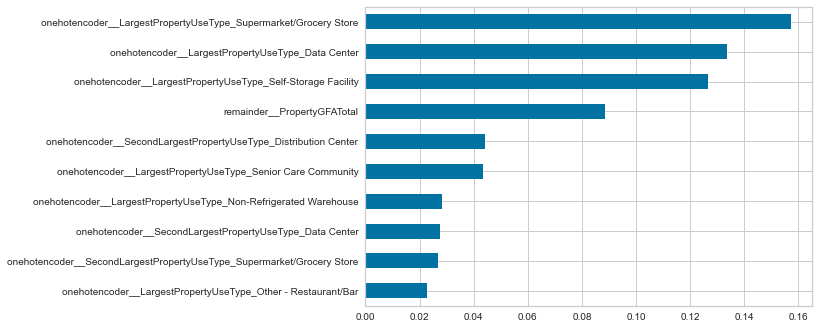

In [30]:
feat_importances_xgbr_ess = pd.Series(xgbr_ess.feature_importances_, index = features)

feat_importances_xgbr_ess.nlargest(10).sort_values().plot(kind = 'barh')

# Prédictions des émissions de CO2 des bâtiments, sans ENERGYSTARScore

In [31]:
#On charge notre jeu de données
co2_no_star = pd.read_csv('P4_co2.csv')
co2_no_star.drop(columns = ['Unnamed: 0', 'ENERGYSTARScore'], inplace = True)
print('Notre jeu de données comporte :', co2_no_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [32]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = co2_no_star, target = 'TotalGHGEmissions')

In [33]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [34]:
#On regroupe nos résultats dans un DataFrame
df_co2_no_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                 'RMSE', 'Temps de calcul'])
df_co2_no_star.sort_values('Score de test', ascending = False, inplace = True)
df_co2_no_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9993,0.8164,0.62,1.23
RandomForestRegressor(),0.9647,0.7753,0.69,1.77
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9384,0.7447,0.73,0.23
DecisionTreeRegressor(),0.9999,0.6580,0.85,0.03
GradientBoostingRegressor(),0.6689,0.6179,0.89,0.59
KNeighborsRegressor(),0.6307,0.4328,1.09,0.05
Lasso(tol=0.01),0.1358,0.1414,1.34,0.01
LinearRegression(),0.4947,-147190073785.3834,555212.04,0.01
Ridge(),0.4924,-0.1060,1.52,0.00
DummyRegressor(),0.0000,-0.0001,1.45,0.00


## Validation croisée de nos meilleurs modèles pour prédire les émissions de CO2 des bâtiments sans ENERGYSTARScore

In [35]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 3, 5], 'min_samples_leaf' : [1, 5, 10], 'n_estimators' : np.arange(100, 500, 100)}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=300) 

Le meilleur score avec ces hyperparamètres est : 0.7116 

RMSE_CV : 0.68 

Temps de calcul : 289.31 secondes


In [36]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 3, 5], 'base_estimator__min_samples_leaf' : [1, 5, 10],\
               'n_estimators' : np.arange(50, 300, 50),\
               'loss' : ['linear', 'square', 'exponential']}

algo_cv(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'loss': 'linear', 'n_estimators': 100} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100) 

Le meilleur score avec ces hyperparamètres est : 0.7373 

RMSE_CV : 0.61 

Temps de calcul : 941.62 secondes


In [37]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [4, 6, 8],\
               'gamma' : [ 0.0, 0.1, 0.2], 'n_estimators' : [100, 250, 500]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.7335 

RMSE_CV : 0.64 

Temps de calcul : 230.29 secondes


# Analyse de notre meilleur modèle pour la prédiction d'émissions de CO2

In [38]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

ada = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1),\
                        n_estimators = 250, loss = 'exponential') 

#On entraîne notre modèle
ada.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
ada_train = '{:.4f}'.format(ada.score(X_train, y_train))
ada_test = '{:.4f}'.format(ada.score(X_test, y_test))

print("Score d'entraînement : {}".format(ada_train), '\n')
print("Score de test : {}".format(ada_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = ada.predict(X_test)
ada_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE : {}".format(ada_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
ada_time = round(t1 - t0, 2)
print('Temps de calcul :', ada_time, 'secondes')

Score d'entraînement : 0.9991 

Score de test : 0.8235 

RMSE : 0.61 

Temps de calcul : 5.53 secondes


In [39]:
dict_final.update({'AdaBoostRegressor' : [ada_train, ada_test, ada_rmse, ada_time]})

## Feature importance plot - Emissions de CO2

<AxesSubplot:>

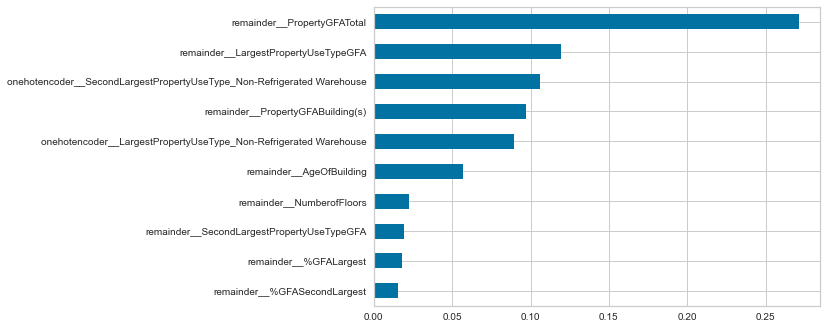

In [40]:
feat_importances_ada = pd.Series(ada.feature_importances_, index = features)

feat_importances_ada.nlargest(10).sort_values().plot(kind = 'barh')

## Learning curves plot - Emissions de CO2

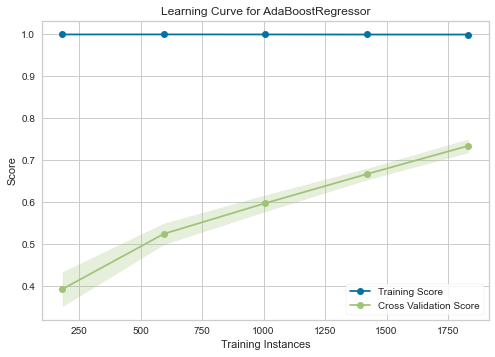

<AxesSubplot:title={'center':'Learning Curve for AdaBoostRegressor'}, xlabel='Training Instances', ylabel='Score'>

In [41]:
learning_curve_ada = LearningCurve(ada, scoring = 'r2')

learning_curve_ada.fit(X_train, y_train)
learning_curve_ada.show()

## Residual plot - Emissions de CO2

<AxesSubplot:title={'center':'Residuals for AdaBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

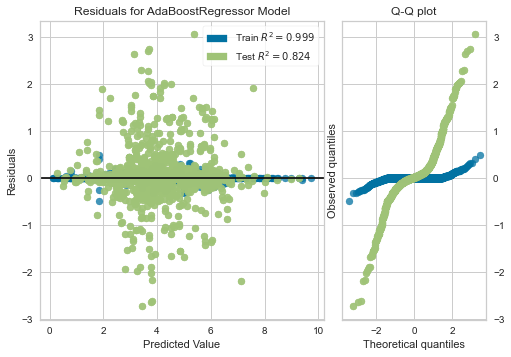

In [42]:
residual_plot_ada = ResidualsPlot(ada, hist = False, qqplot = True)

residual_plot_ada.fit(X_train, y_train)
residual_plot_ada.score(X_test, y_test) 
residual_plot_ada.finalize()
residuals = y_pred - y_test

residual_plot_ada.draw(y_pred, residuals) 

## Prediction Error plot - Emissions de CO2

<AxesSubplot:title={'center':'Prediction Error for AdaBoostRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

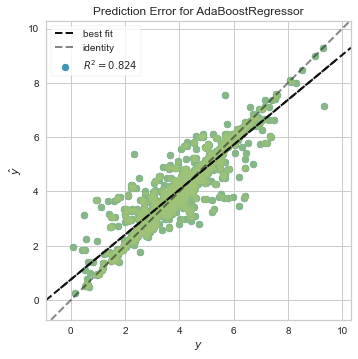

In [43]:
#Prediction Error Plot
prediction_error_ada = PredictionError(ada)

prediction_error_ada.fit(X_train, y_train)
prediction_error_ada.score(X_test, y_test)
prediction_error_ada.finalize()
prediction_error_ada.draw(y_test, y_pred) 

# Prédictions des émissions de CO2 des bâtiments, avec ENERGYSTARScore

In [19]:
#On charge notre jeu de données
co2_with_star = pd.read_csv('P4_co2.csv')
co2_with_star.drop(columns = ['Unnamed: 0'], inplace = True)
print('Notre jeu de données comporte :', co2_with_star.shape[0], 'lignes')

Notre jeu de données comporte : 3273 lignes


In [20]:
#Preprocessing de nos données
X_train, X_test, y_train, y_test, features = preprocessing(data = co2_with_star, target = 'TotalGHGEmissions')

In [21]:
for model in modeles:
    algo(model, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

In [22]:
#On regroupe nos résultats dans un DataFrame
df_co2_with_star = pd.DataFrame.from_dict(data_model, orient = 'index', columns = ['Score entraînement', 'Score de test',\
                                                                                   'RMSE', 'Temps de calcul'])
df_co2_with_star.sort_values('Score de test', ascending = False, inplace = True)
df_co2_with_star.head(len(modeles))

,Score entraînement,Score de test,RMSE,Temps de calcul
AdaBoostRegressor(base_estimator=DecisionTreeRegressor()),0.9995,0.8353,0.59,1.27
RandomForestRegressor(),0.9661,0.7876,0.67,1.80
"XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,\n colsample_bynode=1, colsample_bytree=1, enable_categorical=False,\n gamma=0, gpu_id=-1, importance_type=None,\n interaction_constraints='', learning_rate=0.300000012,\n max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,\n monotone_constraints='()', n_estimators=100, n_jobs=16,\n num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,\n reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',\n validate_parameters=1, verbosity=None)",0.9619,0.7849,0.67,0.23
DecisionTreeRegressor(),1.0000,0.6599,0.84,0.03
GradientBoostingRegressor(),0.7055,0.6562,0.85,0.61
KNeighborsRegressor(),0.5799,0.3349,1.18,0.05
Lasso(tol=0.01),0.1572,0.1576,1.33,0.01
LinearRegression(),0.5217,-15884813251.4809,182394.05,0.01
Ridge(),0.5193,-0.0747,1.50,0.01
DummyRegressor(),0.0000,-0.0001,1.45,0.00


## Validation croisée de nos meilleurs modèles pour prédire les émissions de CO2 des bâtiments avec ENERGYSTARScore

In [48]:
#RandomForestRegressor
params_grid = {'max_depth' : [None, 3, 5], 'min_samples_leaf' : [1, 5, 10], 'n_estimators' : np.arange(100, 500, 100)}

algo_cv(RandomForestRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test,\
        y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Les meilleurs hyperparamètres du modèle sont : {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 400} 

Le modèle à utiliser est : RandomForestRegressor(n_estimators=400) 

Le meilleur score avec ces hyperparamètres est : 0.7458 

RMSE_CV : 0.64 

Temps de calcul : 175.7 secondes


In [49]:
#XGBoostRegressor
params_grid = {'learning_rate' : (0.05, 0.10, 0.15), 'max_depth' : [4, 6, 8],\
               'gamma' : [ 0.0, 0.1, 0.2], 'n_estimators' : [100, 250, 500]}

algo_cv(XGBRegressor(), params_grid = params_grid, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Les meilleurs hyperparamètres du modèle sont : {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 500} 

Le modèle à utiliser est : XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None) 

Le meilleur score avec ces hyperparamètres est : 0.7629 

RMSE_CV : 0.59 

Temps de calcul : 153.79 secondes


In [50]:
#AdaBoostRegressor
params_grid = {'base_estimator__max_depth' : [None, 3, 5], 'base_estimator__min_samples_leaf' : [1, 5, 10],\
               'n_estimators' : np.arange(50, 300, 50),\
               'loss' : ['linear', 'square', 'exponential']}

algo_cv(AdaBoostRegressor(base_estimator=DecisionTreeRegressor()), params_grid = params_grid, X_train = X_train,\
        X_test = X_test, y_train = y_train, y_test = y_test)

Fitting 5 folds for each of 135 candidates, totalling 675 fits
Les meilleurs hyperparamètres du modèle sont : {'base_estimator__max_depth': None, 'base_estimator__min_samples_leaf': 1, 'loss': 'linear', 'n_estimators': 100} 

Le modèle à utiliser est : AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100) 

Le meilleur score avec ces hyperparamètres est : 0.7854 

RMSE_CV : 0.60 

Temps de calcul : 505.05 secondes


## Feature importance plot - Emissions de CO2 avec Energy Star Score

De nouveau, nous allons uniquement nous intéresser au Feagture importance plot pour notre modèle qui prend en compte l'*ENERGYSTARScore*".

In [23]:
#On souhaite savoir combien de temps notre modèle prend à se faire
t0 = time.time()

ada_ess = AdaBoostRegressor(base_estimator = DecisionTreeRegressor(max_depth = None, min_samples_leaf = 1),\
                        n_estimators = 250, loss = 'exponential') 

#On entraîne notre modèle
ada_ess.fit(X_train, y_train)
    
#On calcule nos scores obtenus avec notre premier test (= coefficient de détermination R2)
ada_ess_train = '{:.4f}'.format(ada_ess.score(X_train, y_train))
ada_ess_test = '{:.4f}'.format(ada_ess.score(X_test, y_test))

print("Score d'entraînement : {}".format(ada_ess_train), '\n')
print("Score de test : {}".format(ada_ess_test), '\n')
    
#On calcule nos prédictions et la racine carré de l'erreur quadratique moyenne
y_pred = ada_ess.predict(X_test)
ada_ess_rmse = '{:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE : {}".format(ada_ess_rmse), '\n')

#On calcule le temps de calcul
t1 = time.time()
ada_ess_time = round(t1 - t0, 2)
print('Temps de calcul :', ada_ess_time, 'secondes')

Score d'entraînement : 0.9999 

Score de test : 0.8389 

RMSE : 0.58 

Temps de calcul : 6.96 secondes


In [24]:
dict_final.update({'AdaBoostRegressor avec ESS' : [ada_ess_train, ada_ess_test, ada_ess_rmse, ada_ess_time]})

<AxesSubplot:>

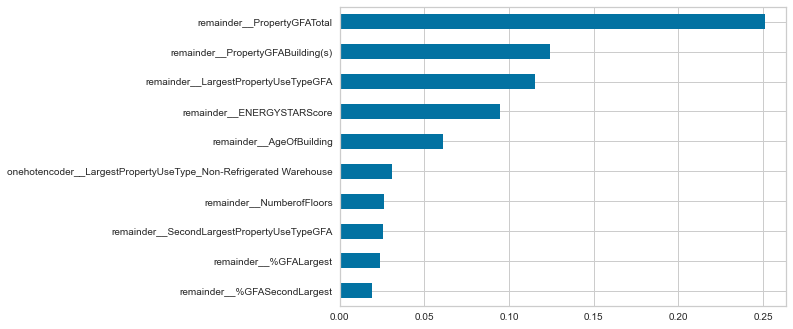

In [25]:
feat_importances_ada_ess = pd.Series(ada_ess.feature_importances_, index = features)

feat_importances_ada_ess.nlargest(10).sort_values().plot(kind = 'barh')

# Nos modèles finaux

In [26]:
df_final = pd.DataFrame.from_dict(dict_final, orient = 'index', columns = ["Score d'entraînement", 'Score de test',\
                                                                                 'RMSE', 'Temps de calcul'])
df_final.head()

,Score d'entraînement,Score de test,RMSE,Temps de calcul
XGBoostRegressor,0.9994,0.8440,0.53,1.44
AdaBoostRegressor avec ESS,0.9999,0.8389,0.58,6.96


In [55]:
for col in df_final.columns:
    df_final[col] = pd.to_numeric(df_final[col])

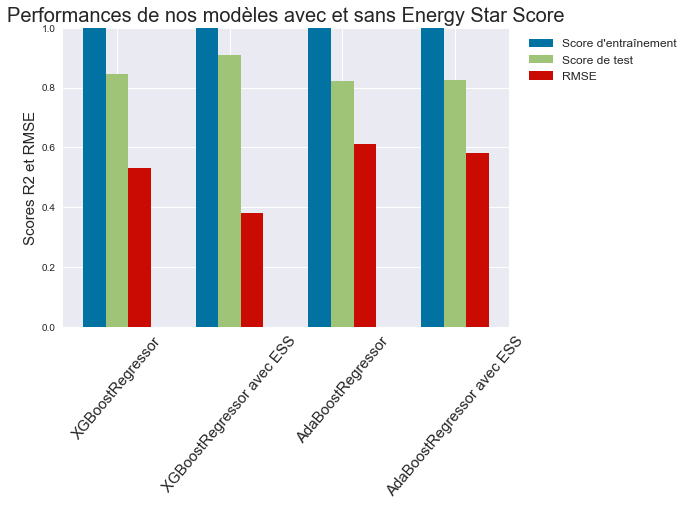

In [56]:
x = df_final.index
y = df_final["Score d'entraînement"]
z = df_final['Score de test']
w = df_final['RMSE']
v = df_final['Temps de calcul']

_x = np.arange(len(x))

plt.style.use('seaborn-darkgrid')
plt.bar(_x-0.2, y, 0.2, color = 'b', align = 'center')
plt.bar(_x, z, 0.2, color = 'g', align = 'center')
plt.bar(_x + 0.2, w, 0.2, color = 'r', align = 'center')
plt.xticks(_x, x, rotation = 50, fontsize = 15)
plt.ylim([0, 1])
plt.ylabel('Scores R2 et RMSE', fontsize = 15)

plt.title('Performances de nos modèles avec et sans Energy Star Score', fontsize = 20)
plt.legend(["Score d'entraînement", 'Score de test', 'RMSE'], bbox_to_anchor = (1.4, 1.), fontsize = 12)

plt.show()

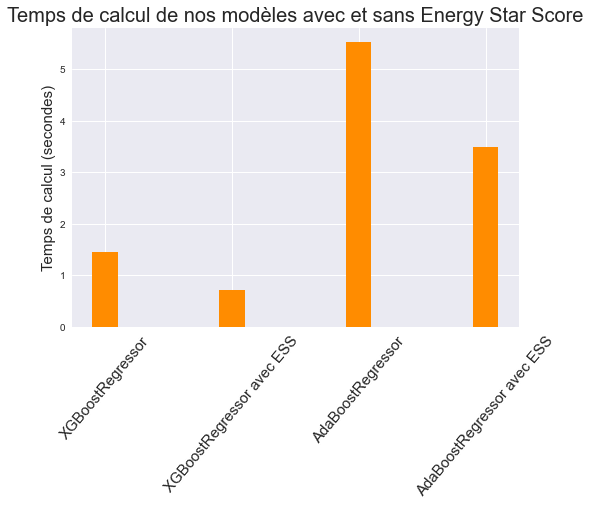

In [57]:
plt.bar(_x, v, 0.2, color = 'darkorange', align = 'center')
plt.ylabel('Temps de calcul (secondes)', fontsize = 15)
plt.xticks(_x, x, rotation = 50, fontsize = 15)
plt.title('Temps de calcul de nos modèles avec et sans Energy Star Score', fontsize = 20)

plt.show()